In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_store = pd.read_csv("store.csv")
df_train = pd.read_csv("train.csv", parse_dates=[2])
df_test = pd.read_csv("test.csv", parse_dates=[3])

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_train.info()
df_store.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-nul

In [4]:
#数据处理
def data_process(data, features):
    data.loc[data['Open'].isnull(), 'Open'] = 1
    data.loc[data['CompetitionDistance'].isnull(), 'CompetitionDistance'] = 0
    features.extend(['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday'])
    
    #calculate log(sales) and log(customers)
    data.loc[data['isTrain'] == 1, 'SalesLog'] = np.log1p(data.loc[data['isTrain'] == 1]['Sales'])
    data.loc[data['isTrain'] == 1, 'CustomersLog'] = np.log1p(data.loc[data['isTrain'] == 1]['Customers'])

    #change StoreType / Assortment / StateHoliday values
    replace_dict = {'a': 1, 'b': 2, 'c':3, 'd':4, '0':0}
    data.replace(replace_dict, inplace=True)
    features.extend(['StoreType', 'Assortment', 'StateHoliday'])
    
    #Date column split
    data['Year'] = data['Date'].apply(lambda x: x.year)
    data['Month'] = data['Date'].apply(lambda x: x.month)
    data['Day'] = data.Date.dt.day  
    data['DayOfWeek'] = data.Date.dt.dayofweek 
    data['WeekOfYear'] = data['Date'].apply(lambda x: x.weekofyear)
    data['DayOfYear'] = data.Date.dt.dayofyear
    features.extend(['DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear', 'DayOfYear'])
    
    #competition open time in months
    data["CompetitionOpenSinceYear"][(data["CompetitionDistance"] != 0) & (data["CompetitionOpenSinceYear"].isnull())] = 1900#data['CompetitionOpenSinceYear'].median()
    data["CompetitionOpenSinceMonth"][(data["CompetitionDistance"] != 0) & (data["CompetitionOpenSinceMonth"].isnull())] = 1#data['CompetitionOpenSinceMonth'].median()
    data['CompetitionOpen'] = 12 * (data['Year'] - data['CompetitionOpenSinceYear']) +\
                            (data['Month'] - data['CompetitionOpenSinceMonth'])
    features.append('CompetitionOpen')
    
    #promo open time in months
    data['PromoOpen'] = 12 * (data['Year'] - data['Promo2SinceYear']) +\
                        (data['WeekOfYear'] - data['Promo2SinceWeek']) / 4.0
    data.loc[data['Promo2SinceYear'] == 0, 'PromoOpen'] = 0
    features.append('PromoOpen')
    
    #promo month
    month2str = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', \
                 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}  
    data['monthStr'] = data['Month'].map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data['PromoInterval'].unique():
        if interval == interval:  
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1 
    features.append('IsPromoMonth')
    
    #calculate number of schoolholidays this week, last week and next week
    SchoolHolidays = data.groupby(['Store','Year','WeekOfYear'])['SchoolHoliday'].sum().reset_index(name='holidays_thisweek')
    SchoolHolidays['holidays_lastweek'] = 0
    SchoolHolidays['holidays_nextweek'] = 0

    for store in SchoolHolidays.Store.unique().tolist():
        storeLen = len(SchoolHolidays[SchoolHolidays['Store'] == store])
        SchoolHolidays.loc[1:storeLen-1, 'holidays_lastweek'] = SchoolHolidays.loc[0:storeLen-2, 'holidays_thisweek'].values
        SchoolHolidays.loc[0:storeLen-2, 'holidays_nextweek'] = SchoolHolidays.loc[1:storeLen-1, 'holidays_thisweek'].values

    data = pd.merge(data, SchoolHolidays, how='left', on=['Store', 'Year', 'WeekOfYear'])
    features.extend(['holidays_thisweek', 'holidays_lastweek', 'holidays_nextweek'])
    
    #calculate average sales per store, sales per customer, customers per store,
    salesAvgPerStore = data[data.Open == 1].groupby(['Store'])['Sales'].mean()
    customersAvgPerStore = data[data.Open == 1].groupby(['Store'])['Customers'].mean()
    salesAvgPerCustomer = salesAvgPerStore / customersAvgPerStore        
    data = pd.merge(data, salesAvgPerStore.reset_index(name='SalesAvgPerStore'), how='left', on='Store')
    data = pd.merge(data, customersAvgPerStore.reset_index(name='CustomersAvgPerStore'), how='left', on='Store')
    data = pd.merge(data, salesAvgPerCustomer.reset_index(name='SalesAvgPerCustomer'), how='left', on='Store')
    features.extend(['SalesAvgPerStore', 'CustomersAvgPerStore', 'SalesAvgPerCustomer'])
        
    #calculate average sales per stateholiday, sales per schoolholiday
    data['isStateHoliday'] = 0
    data.loc[data.StateHoliday != 0, 'isStateHoliday'] = 1
    salesPerStateHoliday = data[data.isStateHoliday == 1].groupby(['Store'])['Sales'].mean()
    salesPerSchoolHoliday = data[data.SchoolHoliday == 1].groupby(['Store'])['Sales'].mean()
    data = pd.merge(data, salesPerStateHoliday.reset_index(name='SalesPerStateHoliday'), how='left', on='Store')
    data = pd.merge(data, salesPerSchoolHoliday.reset_index(name='SalesPerSchoolHoliday'), how='left', on='Store')
    features.extend(['SalesPerStateHoliday', 'SalesPerSchoolHoliday'])
        
    #calculate average and median sales and customers per store per day of week
    salesAvgPerDow = data.groupby(['Store', 'DayOfWeek'])['Sales'].mean()
    salesMedPerDow = data.groupby(['Store', 'DayOfWeek'])['Sales'].median()
    customersAvgPerDow = data.groupby(['Store', 'DayOfWeek'])['Customers'].mean()
    customersMedPerDow = data.groupby(['Store', 'DayOfWeek'])['Customers'].median()
    data = pd.merge(data, salesAvgPerDow.reset_index(name='SalesAvgPerDow'), how='left', on=['Store', 'DayOfWeek'])
    data = pd.merge(data, salesMedPerDow.reset_index(name='SalesMedPerDow'), how='left', on=['Store', 'DayOfWeek'])
    data = pd.merge(data, customersAvgPerDow.reset_index(name='CustomersAvgPerDow'), how='left', on=['Store', 'DayOfWeek'])
    data = pd.merge(data, customersMedPerDow.reset_index(name='CustomersMedPerDow'), how='left', on=['Store', 'DayOfWeek'])
    features.extend(['SalesAvgPerDow', 'SalesMedPerDow', 'CustomersAvgPerDow', 'CustomersMedPerDow'])
    
    data.fillna(0, inplace=True)
    return data

In [5]:
df_test['isTrain'] = 0
df_train['isTrain'] = 1
df_train_test = pd.concat([df_train, df_test])
df_train_test = df_train_test.loc[~((df_train_test.isTrain == 1) & (df_train_test.Sales == 0))]
all_df = pd.merge(df_train_test, df_store, how='left', on='Store')
features = []
data = data_process(all_df, features)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
train_data = data[data['isTrain'] == 1]
test_data = data[data['isTrain'] == 0]
print(features)
train_data.describe()

['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday', 'StoreType', 'Assortment', 'StateHoliday', 'DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear', 'DayOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth', 'holidays_thisweek', 'holidays_lastweek', 'holidays_nextweek', 'SalesAvgPerStore', 'CustomersAvgPerStore', 'SalesAvgPerCustomer', 'SalesPerStateHoliday', 'SalesPerSchoolHoliday', 'SalesAvgPerDow', 'SalesMedPerDow', 'CustomersAvgPerDow', 'CustomersMedPerDow']


,Customers,DayOfWeek,Id,Open,Promo,Sales,SchoolHoliday,StateHoliday,Store,isTrain,...,SalesAvgPerStore,CustomersAvgPerStore,SalesAvgPerCustomer,isStateHoliday,SalesPerStateHoliday,SalesPerSchoolHoliday,SalesAvgPerDow,SalesMedPerDow,CustomersAvgPerDow,CustomersMedPerDow
count,844338.000000,844338.000000,844338.0,844338.0,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.0,...,844338.000000,844338.000000,844338.000000,844338.000000,844338.00000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000
mean,762.777166,2.520350,0.0,1.0,0.446356,6955.959134,0.193578,0.001418,558.421374,1.0,...,6955.959134,762.777166,9.589319,0.001078,1018.90627,7187.113768,6955.959134,6955.288130,762.777166,759.015219
std,401.194153,1.723712,0.0,0.0,0.497114,3103.815515,0.395102,0.047578,321.730861,0.0,...,2408.370239,365.361379,1.985306,0.032812,2927.47997,2440.381506,2603.783784,2672.638776,378.835686,378.667327
min,8.000000,0.000000,0.0,1.0,0.000000,46.000000,0.000000,0.000000,1.000000,1.0,...,2703.736573,240.183099,3.513703,0.000000,0.00000,2990.681250,935.559701,866.500000,120.902985,114.000000
25%,519.000000,1.000000,0.0,1.0,0.000000,4859.000000,0.000000,0.000000,280.000000,1.0,...,5323.455243,544.337179,8.098467,0.000000,0.00000,5517.412844,5256.348485,5196.000000,534.187970,530.000000
50%,676.000000,2.000000,0.0,1.0,0.000000,6369.000000,0.000000,0.000000,558.000000,1.0,...,6615.434783,682.770408,9.406206,0.000000,0.00000,6870.007812,6590.750000,6549.500000,678.679104,677.000000
75%,893.000000,4.000000,0.0,1.0,1.000000,8360.000000,0.000000,0.000000,837.000000,1.0,...,7985.847436,869.450000,10.924144,0.000000,0.00000,8259.731034,8141.354331,8155.000000,883.250000,881.000000
max,7388.000000,6.000000,0.0,1.0,1.000000,41551.000000,1.000000,3.000000,1115.000000,1.0,...,21757.483418,3403.458599,16.162639,1.000000,31898.87500,22747.201258,28450.328358,28347.500000,4366.440299,4394.000000


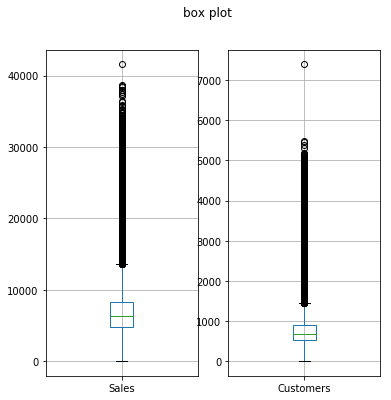

In [7]:
plt.figure(figsize=(6, 6))
plt.suptitle('box plot')
plt.subplot(1, 2, 1)
train_data[['Sales']].boxplot()
plt.subplot(1, 2, 2)
train_data[['Customers']].boxplot()

Text(0.5,0.98,'the distribution of Sales&SalesLog')

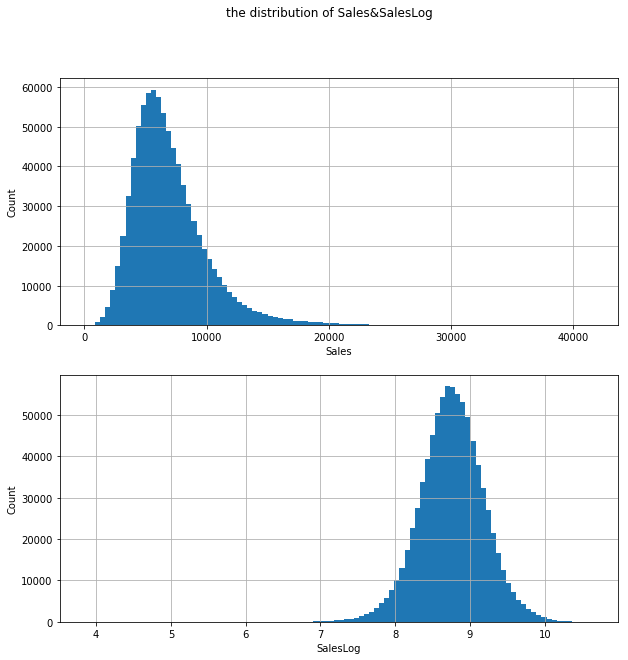

In [8]:
#sales hist
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
sales_fig = train_data.loc[train_data['Sales']>0, 'Sales'].hist(bins=100)
sales_fig.set_xlabel('Sales')
sales_fig.set_ylabel('Count')
#log(sales) hist
plt.subplot(2, 1, 2)
saleslog_fig = train_data.loc[train_data['Sales']>0, 'SalesLog'].hist(bins=100)
saleslog_fig.set_ylabel('Count')
saleslog_fig.set_xlabel('SalesLog')
plt.suptitle('the distribution of Sales&SalesLog')

Text(0.5,0.98,'the distribution of Customers&CustomersLog')

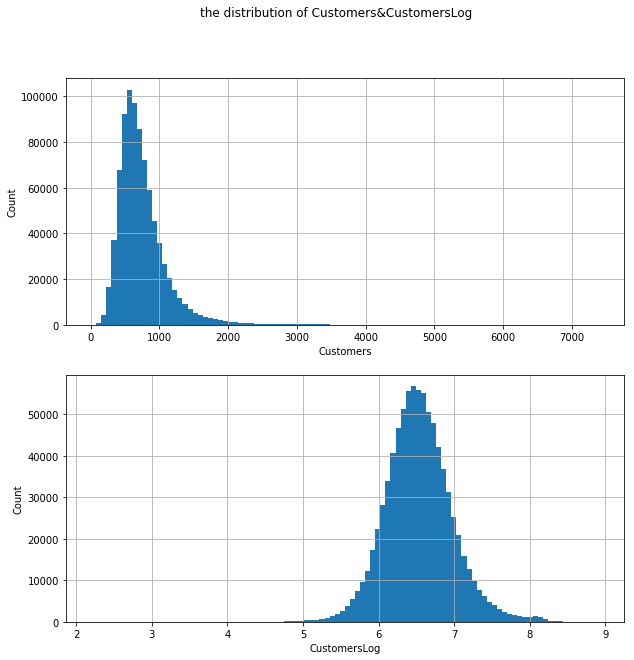

In [9]:
#sales hist
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
sales_fig = train_data.loc[train_data['Customers']>0, 'Customers'].hist(bins=100)
sales_fig.set_xlabel('Customers')
sales_fig.set_ylabel('Count')
#log(sales) hist
plt.subplot(2, 1, 2)
saleslog_fig = train_data.loc[train_data['Customers']>0, 'CustomersLog'].hist(bins=100)
saleslog_fig.set_ylabel('Count')
saleslog_fig.set_xlabel('CustomersLog')
plt.suptitle('the distribution of Customers&CustomersLog')

,Sales,Customers
Promo,,
0,5459.0,610.0
1,7650.0,757.0


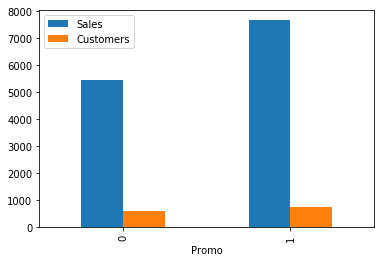

In [10]:
#promo effect
#sales & customers per day 
df = train_data.groupby(['Promo'])['Sales','Customers'].median()
df.plot(kind='bar')
df.head()

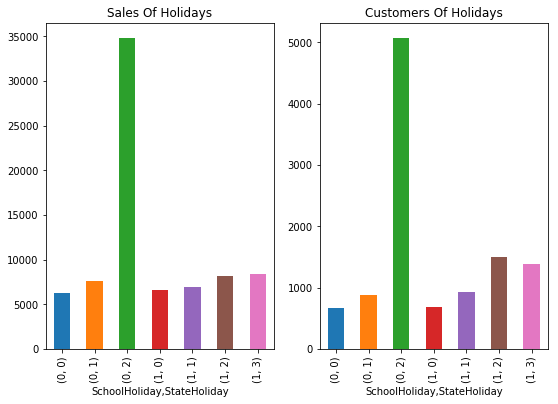

In [11]:
#holiday effect
dfs = train_data.groupby(['SchoolHoliday', 'StateHoliday'])['Sales'].median()
dfc = train_data.groupby(['SchoolHoliday', 'StateHoliday'])['Customers'].median()
plt.figure(figsize=(9, 6))
plt.subplot(1, 2, 1)
dfs.plot(kind='bar', title='Sales Of Holidays')
plt.subplot(1, 2, 2)
dfc.plot(kind='bar', title='Customers Of Holidays')

,Sales,Customers
StoreType,,
1,6285.0,720.0
2,9130.0,1839.5
3,6408.0,756.0
4,6395.0,577.0


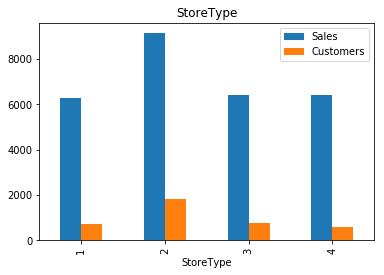

In [12]:
#storetype effect
df = train_data.groupby(['StoreType'])['Sales','Customers'].median()
df.plot(kind='bar',title='StoreType')
df.head()

,Sales,Customers
DayOfWeek,,
0,7539.0,769.0
1,6502.0,684.0
2,6210.0,658.0
3,6246.0,673.0
4,6581.0,698.0
5,5425.0,573.0
6,6876.0,1262.0


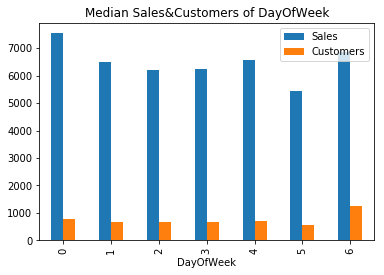

In [13]:
#DayofWeek effect
dfdw = train_data.groupby(['DayOfWeek'])['Sales', 'Customers'].median()
dfdw.plot(kind='bar', title='Median Sales&Customers of DayOfWeek')
dfdw.head(7)

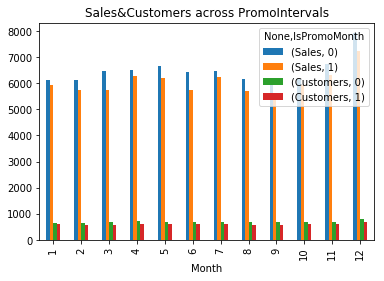

In [14]:
#promo month
dfpm = train_data.groupby(['Month', 'IsPromoMonth'])['Sales', 'Customers'].median()
dfpm.unstack().plot(kind='bar',title='Sales&Customers across PromoIntervals')

In [11]:
#rmspe
def weight(y):
    w = np.zeros(y.shape, dtype=float)
    idx = y != 0
    w[idx] = 1.0 / (y[idx]**2)
    return w

def rmspe_xg(yhat, y):
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = weight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return 'rmspe', rmspe

def rmspe(yhat, y):
    w = weight(y)
    rmspe = np.sqrt(np.mean(w * (yhat - y)**2))
    return rmspe

# create feature map
def create_feature_map(features):
    output = open('xgb.map', 'w')
    for i, f in enumerate(features):
        output.write('{0}\t{1}\tq\n' .format(i, f))
    output.close()

## 决策树模型

In [128]:
from sklearn.cross_validation import train_test_split
features_x = ['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday',
           'StoreType', 'Assortment', 'StateHoliday', 'DayOfWeek', 'Month',
           'Day', 'Year', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']
features_y = ['SalesLog']
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(train_data[features_x], 
                                                        train_data[features_y],
                                                        test_size=0.2, random_state=10)

D:\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [129]:
#DecisionTree
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
dtree = DecisionTreeRegressor(random_state=2)
dtree.fit(X_train_tree, y_train_tree)

y_pred = dtree.predict(X_test_tree)
y = np.expm1(y_test_tree)
y = np.array(y.SalesLog.tolist(), dtype=np.float32)
error = rmspe(np.expm1(y_pred), y)
print(error)

0.18875617507935039


In [135]:
from sklearn.grid_search import GridSearchCV

param_grid = {"min_samples_split": [15, 10, 30],
              "max_depth": [None, 4, 6, 8],
              "min_samples_leaf": [4, 12, 8]
              }
grid_search = GridSearchCV(dtree, param_grid=param_grid)
grid_search.fit(X_train_tree, y_train_tree)

y_pred = grid_search.predict(X_test_tree)

print ("Best parameters:", grid_search.best_params_)

y = np.expm1(y_test_tree)
y = np.array(y.SalesLog.tolist(), dtype=np.float32)
error = rmspe(np.expm1(y_pred), y)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
print(error)

Best parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 15}
0.16522328139828293


[0.20759216 0.25486221 0.16362506 0.01680293 0.00330497 0.03890075
 0.02213818 0.00145956 0.06901582 0.00913246 0.03963852 0.00551298
 0.03702789 0.09376153 0.03538692 0.00183808]


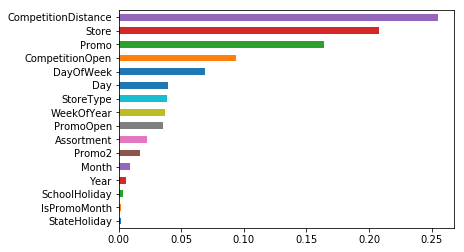

In [136]:
tree_features = pd.Series(dtree.feature_importances_, index=features_x).sort_values()
tree_features.plot(kind='barh')
print(dtree.feature_importances_)

In [138]:
y_vaild = grid_search.predict(test_data[features_x])
result = pd.DataFrame({'ID': test_data['Id'], 'Sales':np.expm1(y_vaild)})
result[['ID']] = result[['ID']].astype(int)
result.to_csv('output/rossmann_dtree.csv', index=False)

 #### DecisionTree Private Score:0.21986

## XGBOOST模型

In [12]:
timeDelta = test_data.Date.max() - test_data.Date.min()
timeDelta1 = train_data.Date.max() - train_data.Date.min()
print('test set timeDelta is %s, train set timeDelta is %s'%(timeDelta, timeDelta1))

test set timeDelta is 47 days 00:00:00, train set timeDelta is 941 days 00:00:00


In [13]:
#split train and test set
#timeDelta = pd.Timedelta(weeks=6)
timeDelta = test_data.Date.max() - test_data.Date.min()
maxDate = train_data.Date.max()
minDate = maxDate - timeDelta
testIn = train_data['Date'].apply(lambda x: (x <= maxDate and x >= minDate))
trainIn = testIn.apply(lambda x: (not x))
X_train = train_data[trainIn]
X_test = train_data[testIn]
y_train = train_data['SalesLog'][trainIn]
y_test = train_data['SalesLog'][testIn]

In [18]:
#xgboost
import xgboost as xgb

dtrain = xgb.DMatrix(X_train[features], y_train)
dtest = xgb.DMatrix(X_test[features], y_test)

In [142]:

nround = 3000
watch_list = [(dtrain, 'train'), (dtest, 'eval')]
params = {
    'objective': 'reg:linear',
    'booster': 'gbtree',
    'eta': 0.03,
    'max_depth': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'silent': 1,
    'seed':1301
}
gbm = xgb.train(params, dtrain, nround, watch_list, 
               early_stopping_rounds=50, verbose_eval=50,
               feval=rmspe_xg)

#save model
#gbm.save_model('0001.model')


[0]	train-rmse:8.01907	eval-rmse:8.052	train-rmspe:0.999809	eval-rmspe:0.999816
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 50 rounds.
[50]	train-rmse:1.75535	eval-rmse:1.77901	train-rmspe:0.824113	eval-rmspe:0.827806
[100]	train-rmse:0.401798	eval-rmse:0.416479	train-rmspe:0.339066	eval-rmspe:0.332784
[150]	train-rmse:0.140141	eval-rmse:0.157256	train-rmspe:0.184973	eval-rmspe:0.145693
[200]	train-rmse:0.106167	eval-rmse:0.126895	train-rmspe:0.164866	eval-rmspe:0.128526
[250]	train-rmse:0.0996	eval-rmse:0.122416	train-rmspe:0.158862	eval-rmspe:0.126916
[300]	train-rmse:0.096278	eval-rmse:0.120513	train-rmspe:0.152622	eval-rmspe:0.125366
[350]	train-rmse:0.094005	eval-rmse:0.119545	train-rmspe:0.140966	eval-rmspe:0.124424
[400]	train-rmse:0.092182	eval-rmse:0.118642	train-rmspe:0.134482	eval-rmspe:0.123276
[450]	train-rmse:0.090487	eval-rmse:0.117835	train-rmspe:0.12505	eval-rmspe:0.122386
[500]	t

In [143]:
y_pred = gbm.predict(xgb.DMatrix(X_test[features]))
#evaluate
error = rmspe(np.expm1(y_pred), X_test['Sales'].values)
print(error)

0.11709473906984764


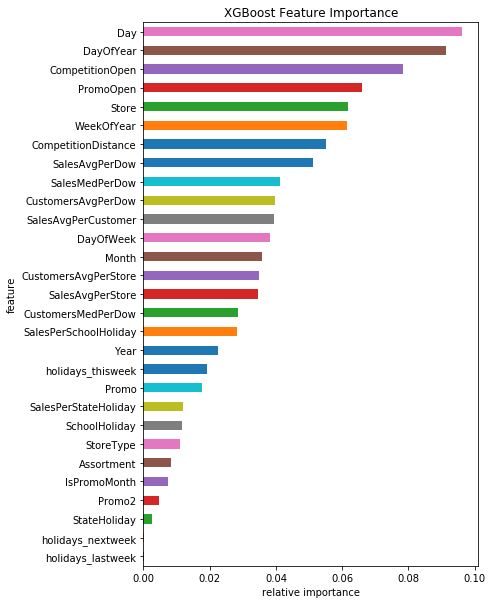

In [160]:
dvaild = xgb.DMatrix(test_data[features])
y_vaild = gbm.predict(dvaild)
result = pd.DataFrame({'ID': test_data['Id'], 'Sales':np.expm1(y_vaild)})
result[['ID']] = result[['ID']].astype(int)
result.to_csv('output/xgb_base.csv', index=False)

#xgb feature importances
#xgb.plot_importance(gbm)
import operator
create_feature_map(features)
importance = gbm.get_fscore(fmap='xgb.map')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df_features = pd.DataFrame(importance, columns=['feature', 'fscore'])
df_features['fscore'] = df_features['fscore'] / df_features['fscore'].sum()

featp = df_features.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)

 #### Xgboost Private Score:0.12202